# import

In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

def redundancy(X_scaled,Y_scaled,component):
    #PARAMETERS
    n_components_cca = component  # number of canonical modes
    n_bootstraps = 500
    seed = 42
    offset = 0.15  # horizontal offset between X|Y and Y|X for dots
    box_offset = 0.25  # offset for boxplots to one side
    box_width = 0.1   # narrow boxplots

    rng = np.random.default_rng(seed)

    #compute redundancy 
    def redundancy(U, V, X, Y):
        r = np.array([np.corrcoef(U[:, i], V[:, i])[0,1] for i in range(U.shape[1])])
        var_X = X.var(axis=0, ddof=1)
        var_Y = Y.var(axis=0, ddof=1)
        red_X = r**2 * var_Y.mean()
        red_Y = r**2 * var_X.mean()
        return red_X, red_Y

    #Bootstrap 
    boot_red_X = np.zeros((n_bootstraps, n_components_cca))
    boot_red_Y = np.zeros((n_bootstraps, n_components_cca))
    n_samples = X_scaled.shape[0]

    for i in range(n_bootstraps):
        idx = rng.integers(0, n_samples, n_samples)
        X_boot = X_scaled[idx]
        Y_boot = Y_scaled[idx]

        cca_boot = CCA(n_components=n_components_cca)
        U_boot, V_boot = cca_boot.fit_transform(X_boot, Y_boot)
        red_X, red_Y = redundancy(U_boot, V_boot, X_boot, Y_boot)
        boot_red_X[i] = red_X
        boot_red_Y[i] = red_Y

    #Plot
    xs = np.arange(1, 2)

    plt.figure(figsize=(4,5))

    # Add narrow boxplots slightly to the right of the dots
    plt.boxplot([boot_red_Y[:, i] for i in range(n_components_cca)][component-1],
                positions=xs+box_offset*1.5, widths=box_width, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='darkblue'))
    plt.boxplot([boot_red_X[:, i] for i in range(n_components_cca)][component-1],
                positions=xs+box_offset, widths=box_width, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', color='red'),
                medianprops=dict(color='darkred'))

    plt.xticks(xs)
    plt.xlabel('Canonical pair')
    plt.ylabel('Redundancy (variance explained)')
    plt.ylim(0, None)
    plt.grid(alpha=0.3)
    
    plt.ylim(0,0.5)

def stadardise_data(X, Y):
    """
    Standardizes the input data X and Y.
    """
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)
    return X_scaled, Y_scaled

def fold_cross_val(full_corrs,null_corrs_all,mode):
    plt.figure(figsize=(3, 3))
    obs = full_corrs[mode]
    nulls = null_corrs_all[:, mode]
    null_95 = np.percentile(nulls, 95)

    # Histogram of null correlations
    plt.hist(nulls, bins=30, color='gray', alpha=0.5, label='Null distribution')

    # Observed correlation
    plt.axvline(obs, color='k', linestyle=':', linewidth=2, label='Observed')

    # 95th percentile line
    plt.axvline(null_95, color='k', linestyle=':', linewidth=2, label='95th percentile null')

    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.title(f'Canonical mode {mode+1}')
    plt.grid(alpha=0.3)
    if mode == 0:
        plt.legend()

    plt.tight_layout()


def plot_cannon_corr(X_scaled,Y_scaled):

    #PARAMETERS #################
    n_components_cca = 4  # your CCA components
    n_shuffles = 200
    seed = 2

    #HELPER: compute canonical correlation #################
    def canonical_corr(U, V):
        U_std = (U - U.mean(axis=0)) / U.std(axis=0, ddof=1)
        V_std = (V - V.mean(axis=0)) / V.std(axis=0, ddof=1)
        return np.array([np.corrcoef(U_std[:, i], V_std[:, i])[0,1] for i in range(U.shape[1])])

    #CCA on full data #################
    cca = CCA(n_components=n_components_cca)
    U_full, V_full = cca.fit_transform(X_scaled, Y_scaled)
    full_corrs = canonical_corr(U_full, V_full)

    #Null distribution (shuffle Y) #################
    null_corrs_all = np.zeros((n_shuffles, n_components_cca))
    rng = np.random.default_rng(seed)

    for i in range(n_shuffles):
        Y_shuffled = rng.permutation(Y_scaled)
        cca = CCA(n_components=n_components_cca)
        U_shuff, V_shuff = cca.fit_transform(X_scaled, Y_shuffled)
        null_corrs_all[i] = canonical_corr(U_shuff, V_shuff)

    null_lower = np.percentile(null_corrs_all, 5, axis=0)
    null_upper = np.percentile(null_corrs_all, 95, axis=0)

    #Plot #################
    xs = np.arange(1, n_components_cca+1)
    plt.figure(figsize=(7,5))
    plt.plot(xs, full_corrs, marker='o', color='blue', label='Full-data observed')
    plt.fill_between(xs, null_lower, null_upper, color='gray', alpha=0.3, label='Null 5-95% CI')
    plt.xlabel('Canonical pair')
    plt.ylabel('Canonical correlation')
    plt.title('CCA canonical correlations (full data) with shuffled null')
    plt.xticks(xs)
    plt.grid(alpha=0.3)
    plt.legend()
    
    return full_corrs,null_corrs_all
        

In [16]:
bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_predictor.csv")
# scale and standardise the data
X_scaled, Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)

# figure A - D

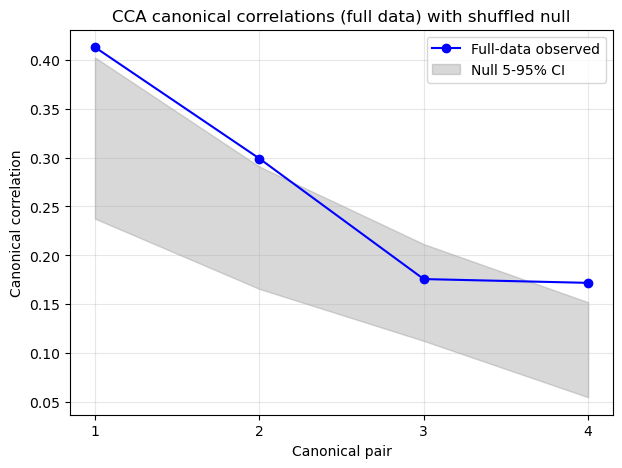

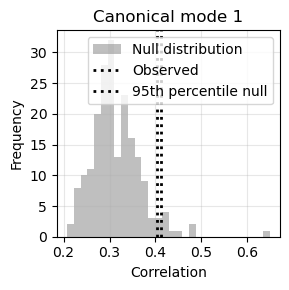

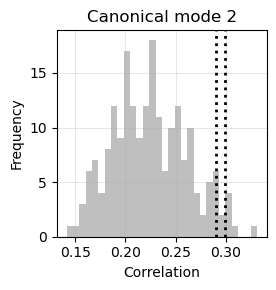

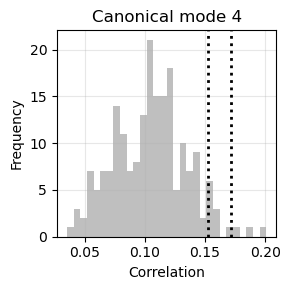

In [17]:
# plot scree 
full_corrs,null_corrs_all = plot_cannon_corr(X_scaled, Y_scaled)
# cross correlations
fold_cross_val(full_corrs,null_corrs_all,0)
fold_cross_val(full_corrs,null_corrs_all,1)
fold_cross_val(full_corrs,null_corrs_all,3)


# figure E & F

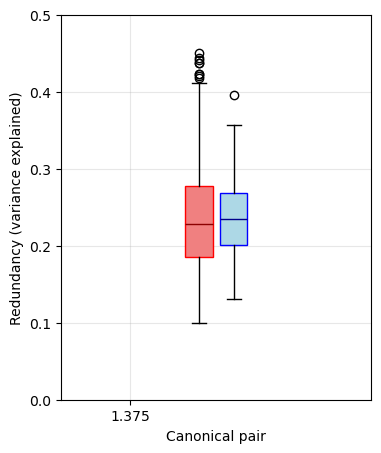

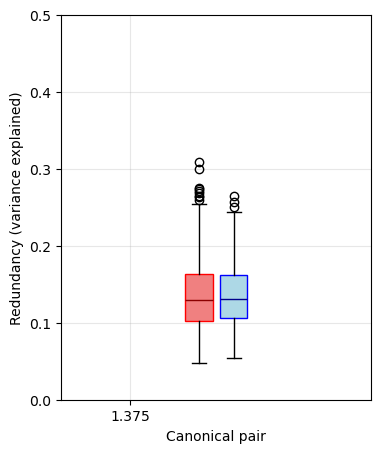

In [70]:
redundancy(X_scaled,Y_scaled,1)
redundancy(X_scaled,Y_scaled,2)

# figure G & H

In [71]:
bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_predictor.csv")
# scale and standardise the data
X_scaled, Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)

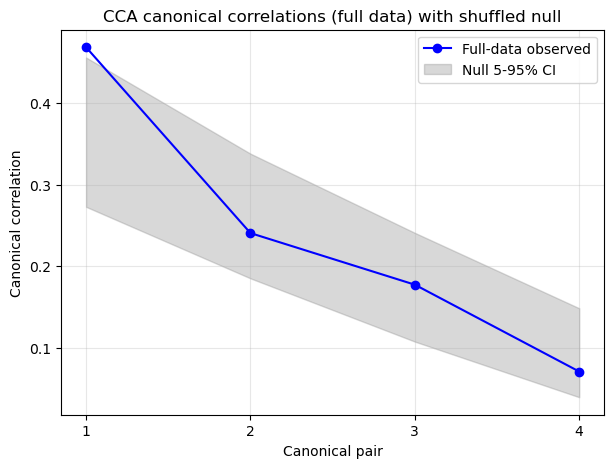

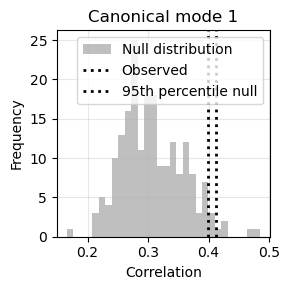

In [72]:
# plot scree 
plot_cannon_corr(X_scaled, Y_shuffled)
# cross correlations
fold_cross_val(full_corrs,null_corrs_all,0)

# figure I

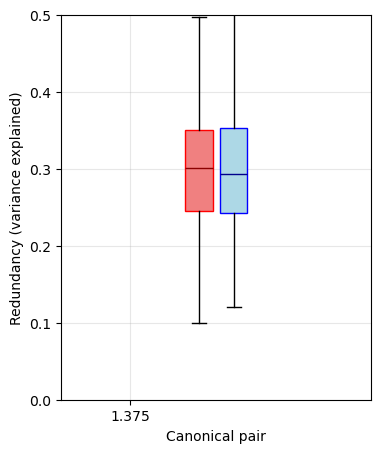

In [73]:
redundancy(X_scaled,Y_scaled,1)


In [4]:
bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_predictor.csv")
# scale and standardise the data
bts_X_scaled, bts_Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)

bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_predictor.csv")
# scale and standardise the data
stb_X_scaled, stb_Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)

In [5]:
figure_dict = {"bts_X_scaled":bts_X_scaled,
               "bts_Y_scaled":bts_Y_scaled,
               'stb_X_scaled':stb_X_scaled,
               'stb_Y_scaled':stb_Y_scaled
                }

In [8]:
save_dict_to_h5(figure_dict, r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED10_data.h5")

In [7]:
import h5py
import numpy as np
import pandas as pd


def save_dict_to_h5(data_dict, filename):

    def save_item(group, key, item):
        # Nested dicts
        if isinstance(item, dict):
            subgroup = group.create_group(key)
            for subkey, subitem in item.items():
                save_item(subgroup, subkey, subitem)

        # Pandas DataFrame
        elif isinstance(item, pd.DataFrame):
            subgroup = group.create_group(key)
            subgroup.attrs['columns'] = np.array(item.columns, dtype='S')
            dt = h5py.string_dtype(encoding='utf-8')
            data_as_strings = np.array(
                [[str(cell) for cell in row] for row in item.values],
                dtype=object
            )
            subgroup.create_dataset('data', data=data_as_strings, dtype=dt)

        # Lists
        elif isinstance(item, list):
            subgroup = group.create_group(key)
            subgroup.attrs['_is_list'] = True  # mark every list as a list
            for i, element in enumerate(item):
                # Nested list or scalar
                if isinstance(element, (list, dict, pd.DataFrame, np.ndarray)):
                    save_item(subgroup, str(i), element)
                else:
                    # Store scalar as dataset inside subgroup
                    subgroup.create_dataset(str(i), data=element)

        # NumPy arrays
        elif isinstance(item, np.ndarray):
            if item.dtype == object:
                dt = h5py.string_dtype(encoding='utf-8')
                arr = np.array([str(x) for x in item.flat], dtype=object).reshape(item.shape)
                group.create_dataset(key, data=arr, dtype=dt)
            else:
                group.create_dataset(key, data=item)

        # Scalars
        else:
            group.create_dataset(key, data=item)

    with h5py.File(filename, 'w') as f:
        for key, value in data_dict.items():
            save_item(f, key, value)